In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

from collections import Counter

In [3]:
df = pd.read_csv('winequality-red.csv')

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


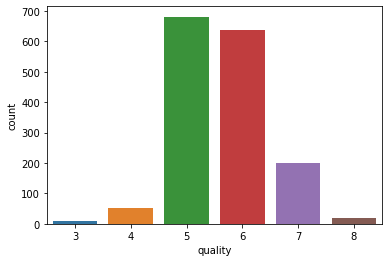

In [5]:
sns.countplot(x=df.quality);

In [6]:
df.quality.median()

6.0

In [7]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

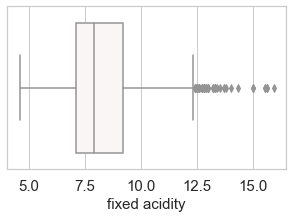

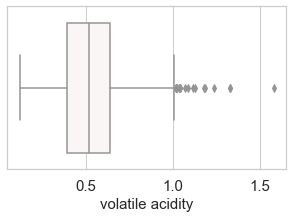

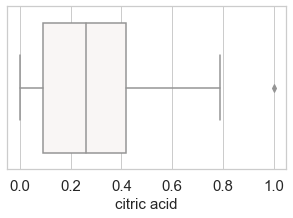

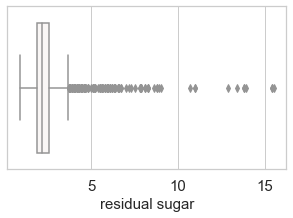

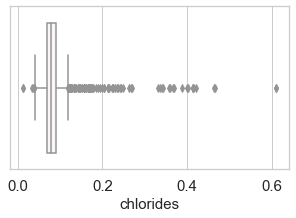

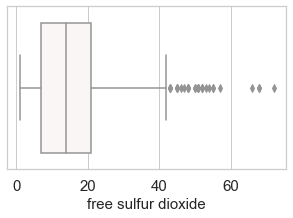

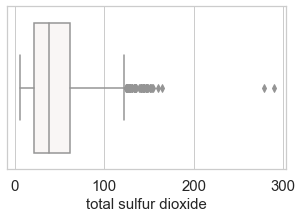

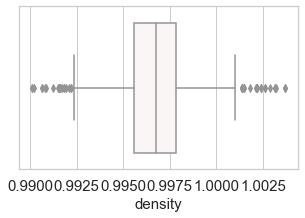

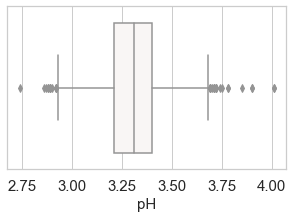

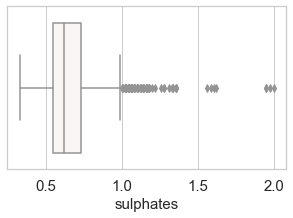

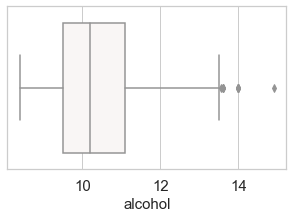

In [8]:
# Boxploty

sns.set_theme(style="whitegrid")

list_columns = list(df.drop("quality", axis=1).columns)

for column in list_columns:
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=df[column], palette="vlag")
    ax.set_xlabel(column,fontsize=15)
    ax.tick_params(labelsize=15);

### Podział na zbiór treningowy i testowy

In [9]:
# Podział na zbiór treningowy i testowy

X = df.drop("quality", axis=1)
y = df.quality

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = df.quality, random_state=0)
y_train.value_counts()

5    477
6    446
7    139
4     37
8     13
3      7
Name: quality, dtype: int64

### Oversampling / Undersampling

In [10]:
# # instantiating over and under sampler
over_strategy = {3: 177, 4: 177, 8: 177}                      # 50% średniej z 3 najliczniejszych klas
over = RandomOverSampler(sampling_strategy=over_strategy)
under_strategy = {5: 382, 6: 357}                             # 80% wartości każdej z dwóch najliczniejszych klas
under = RandomUnderSampler(sampling_strategy=under_strategy)

# # first performing oversampling to minority class
X_over, y_over = over.fit_resample(X_train, y_train)
print(f"Oversampled: {Counter(y_over)}")

# # now to comine under sampling 
X_combined, y_combined = under.fit_resample(X_over, y_over)
print(f"Combined Random Sampling: {Counter(y_combined)}")

Oversampled: Counter({5: 477, 6: 446, 8: 177, 4: 177, 3: 177, 7: 139})
Combined Random Sampling: Counter({5: 382, 6: 357, 3: 177, 4: 177, 8: 177, 7: 139})


In [12]:
# # instantiating over and under sampler
# over_strategy = {3: 177, 4: 177, 8: 177}                      # 50% średniej z 3 najliczniejszych klas
# over = SMOTE(sampling_strategy=over_strategy, random_state=20)
# under_strategy = {5: 382, 6: 357}                             # 80% wartości każdej z dwóch najliczniejszych klas
# under = RandomUnderSampler(sampling_strategy=under_strategy)

# # now to comine over and under sampling
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)

# X_combined, y_combined = pipeline.fit_resample(X_train, y_train)
# print(f"Oversampled: {Counter(y_combined)}")

Oversampled: Counter({5: 382, 6: 357, 3: 177, 4: 177, 8: 177, 7: 139})


In [11]:
y_combined.value_counts()

5    382
6    357
3    177
4    177
8    177
7    139
Name: quality, dtype: int64

### Usuwanie outlier'ów

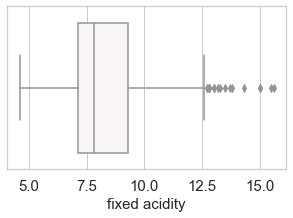

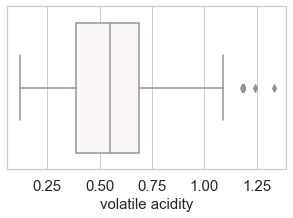

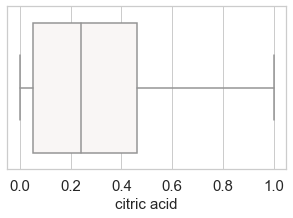

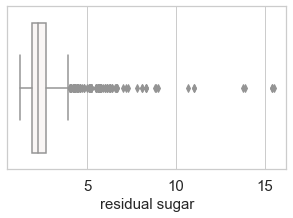

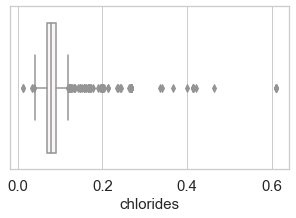

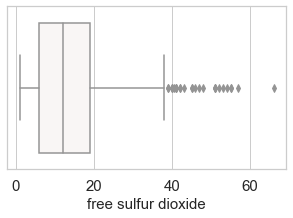

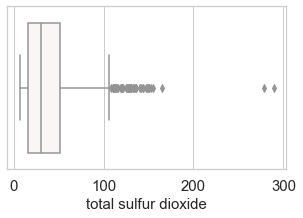

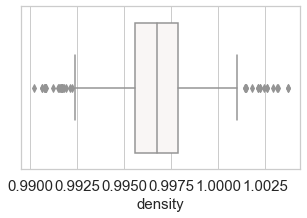

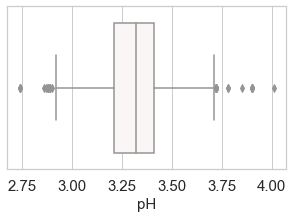

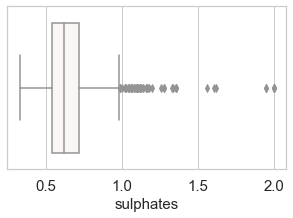

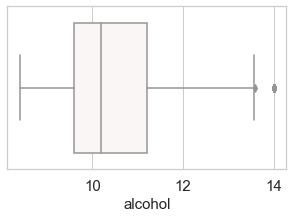

In [12]:
# Boxploty przed usunięciem outlier'ów

sns.set_theme(style="whitegrid")

list_columns_comb = list(X_combined.columns)

for column in list_columns_comb:
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=X_combined[column], palette="vlag")
    ax.set_xlabel(column,fontsize=15)
    ax.tick_params(labelsize=15);

In [13]:
# Usuwanie outlier'ów z zestawu treningowego

def drop_outliers(dff, column):
    iqr = np.percentile(dff[column], 75) - np.percentile(dff[column], 25)
    dff.drop(dff[dff[column] < np.percentile(dff[column], 25) - 3.0 * iqr].index, inplace=True)
    dff.drop(dff[dff[column] > np.percentile(dff[column], 75) + 3.0 * iqr].index, inplace=True)
    return dff

In [14]:
df_train = pd.concat([X_combined, y_combined], axis=1)
df_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.7,0.760,0.02,1.80,0.078,6.0,12.0,0.99600,3.55,0.63,9.95,3
1,10.4,0.610,0.49,2.10,0.200,5.0,16.0,0.99940,3.16,0.63,8.40,3
2,7.1,0.875,0.05,5.70,0.082,3.0,14.0,0.99808,3.40,0.52,10.20,3
3,8.3,1.020,0.02,3.40,0.084,6.0,11.0,0.99892,3.48,0.49,11.00,3
4,7.4,1.185,0.00,4.25,0.097,5.0,14.0,0.99660,3.63,0.54,10.70,3


In [15]:
df_train.shape

(1409, 12)

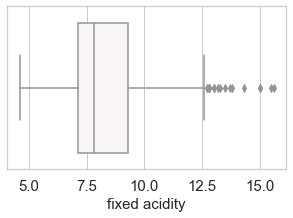

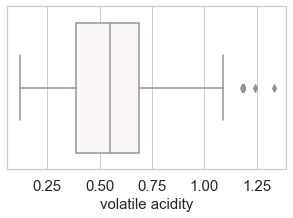

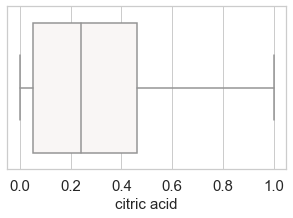

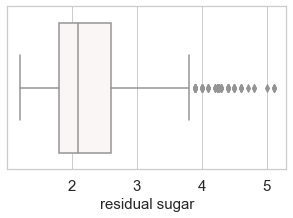

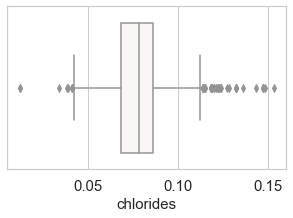

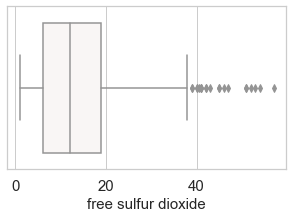

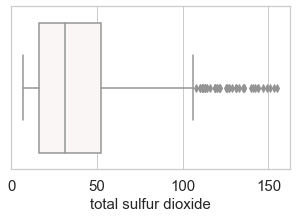

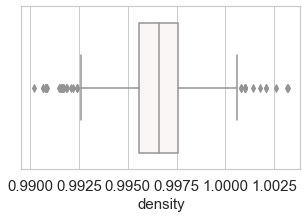

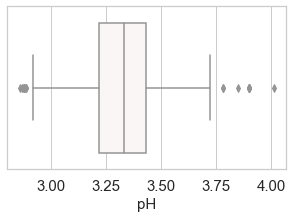

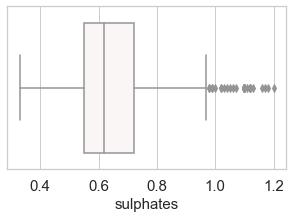

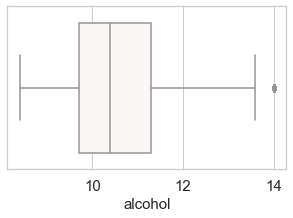

In [16]:
# Boxploty po usunięciu outlier'ów

for column in list_columns:
    drop_outliers(df_train, column=column)
    
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=df_train[column], palette="vlag")
    ax.set_xlabel(column,fontsize=15)
    ax.tick_params(labelsize=15);

In [17]:
df_train.shape

(1218, 12)

In [18]:
X_train_outlier = df_train.drop("quality", axis=1)
y_train_outlier = df_train.quality

y_train_outlier.value_counts()

5    336
6    330
8    167
4    162
7    125
3     98
Name: quality, dtype: int64

In [19]:
# Usuwanie outlier'ów z zestawu testowego (z wykorzystaniem iqr i percentyli z zestawu treningowego)

def drop_outliers_test(df_train, df_test, column):
    iqr = np.percentile(df_train[column], 75) - np.percentile(df_train[column], 25)
    df_test.drop(df_test[df_test[column] < np.percentile(df_train[column], 25) - 3.0 * iqr].index, inplace=True)
    df_test.drop(df_test[df_test[column] > np.percentile(df_train[column], 75) + 3.0 * iqr].index, inplace=True)
    return df_test

In [20]:
# Sprawdzenie przed usunięciem

y_test.value_counts()

5    204
6    192
7     60
4     16
8      5
3      3
Name: quality, dtype: int64

In [21]:
df_test = pd.concat([X_test, y_test], axis=1)
df_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
435,12.3,0.39,0.63,2.30,0.091,6.0,18.0,1.00040,3.16,0.49,9.5,5
125,9.0,0.62,0.04,1.90,0.146,27.0,90.0,0.99840,3.16,0.70,9.4,5
1245,7.4,0.55,0.19,1.80,0.082,15.0,34.0,0.99655,3.49,0.68,10.5,5
721,8.9,0.48,0.24,2.85,0.094,35.0,106.0,0.99820,3.10,0.53,9.2,5
289,11.6,0.42,0.53,3.30,0.105,33.0,98.0,1.00100,3.20,0.95,9.2,5


In [22]:
df_test.shape

(480, 12)

In [23]:
df_train_2 = pd.concat([X_combined, y_combined], axis=1)
df_train_2.shape

(1409, 12)

In [24]:
for column in list_columns:
    drop_outliers_test(df_train_2, df_test, column=column)

In [25]:
# Sprawdzenie po usunięciu

df_test.shape

(441, 12)

In [26]:
X_test_outlier = df_test.drop("quality", axis=1)
y_test_outlier = df_test.quality

y_test_outlier.value_counts()

5    187
6    180
7     53
4     14
8      4
3      3
Name: quality, dtype: int64

### Normalizacja

In [27]:
# Normalizacja zestawu treningowego do rozkładu normalnego, wyznaczenie wartości średnich i odchyleń standardowych
# https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

scaler = StandardScaler()
scaler.fit(X_train_outlier)

X_train_std = scaler.transform(X_train_outlier)

print(scaler.mean_, scaler.scale_)

[ 8.23817734  0.55776273  0.25686371  2.36707718  0.07842365 13.97865353
 39.68144499  0.99653842  3.33494253  0.64589491 10.61670772] [1.74675744e+00 2.20391647e-01 2.02153065e-01 7.19813876e-01
 1.66092294e-02 9.39357661e+00 2.83357755e+01 1.87270346e-03
 1.64463216e-01 1.41476133e-01 1.16493528e+00]


In [28]:
# Normalizacja zestawu testowego do rozkładu normalnego z wykorzystaniem wartości średnich i odch. std z zestawu treningowego

X_test_std = scaler.transform(X_test_outlier)

### KNN

In [315]:
# Model KNN

model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train_std, y_train_outlier)

cross_val_score(model_KNN, X_train_std, y_train_outlier, cv=5)

array([0.60956175, 0.62549801, 0.64541833, 0.624     , 0.644     ])

In [316]:
model_KNN.score(X_test_std, y_test_outlier)

0.48409090909090907

In [317]:
y_pred_KNN = model_KNN.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_KNN))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_KNN))

Confusion matrix - tablica pomyłek
 [[  0   2   0   0   0   0]
 [  2   3   1   8   0   0]
 [  5  28 103  44   8   0]
 [  1  20  45  86  17  10]
 [  0   2   3  20  20   8]
 [  0   0   0   2   1   1]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.05      0.21      0.09        14
           5       0.68      0.55      0.61       188
           6       0.54      0.48      0.51       179
           7       0.43      0.38      0.40        53
           8       0.05      0.25      0.09         4

    accuracy                           0.48       440
   macro avg       0.29      0.31      0.28       440
weighted avg       0.56      0.48      0.52       440



In [318]:
# Dobór optymalnych parametrów dla modelu (ten etap jest powtarzany kilka razy żeby dobrać najlepsze zakresy)

param_grid_KNN = {
            "n_neighbors": list(range(2,31)),
            "weights": ["uniform"],
            "metric": ["minkowski"],
            "p": [1, 2, 3, 4, 10, 20],
            "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
#             "leaf_size": [1, 2, 3, 4, 5, 10, 20]
             }

grid_KNN = GridSearchCV(model_KNN, param_grid=param_grid_KNN, cv=5, scoring="f1_micro", verbose=0, n_jobs=-1)
grid_KNN.fit(X_train_std, y_train_outlier)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['minkowski'],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30],
                         'p': [1, 2, 3, 4, 10, 20], 'weights': ['uniform']},
             scoring='f1_micro')

In [319]:
print("Najlepsze parametry: ", grid_KNN.best_params_)
print("Najwyższy score: ", grid_KNN.best_score_)

Najlepsze parametry:  {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
Najwyższy score:  0.66798406374502


In [320]:
# Zastosowanie najlepszych parametrów dla modelu

model_KNN_best = KNeighborsClassifier(n_neighbors=2, p=1)

model_KNN_best.fit(X_train_std, y_train_outlier)

cross_val_score(model_KNN_best, X_train_std, y_train_outlier, cv=5)

array([0.64541833, 0.6812749 , 0.70119522, 0.648     , 0.664     ])

In [321]:
model_KNN_best.score(X_test_std, y_test_outlier)

0.5159090909090909

In [322]:
y_pred_KNN2 = model_KNN_best.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_KNN2))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_KNN2, zero_division=1))

Confusion matrix - tablica pomyłek
 [[  0   2   0   0   0   0]
 [  2   5   3   4   0   0]
 [  4  29 124  28   3   0]
 [  1  21  58  74  17   8]
 [  0   2   5  17  24   5]
 [  0   0   0   1   3   0]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.08      0.36      0.14        14
           5       0.65      0.66      0.66       188
           6       0.60      0.41      0.49       179
           7       0.51      0.45      0.48        53
           8       0.00      0.00      0.00         4

    accuracy                           0.52       440
   macro avg       0.31      0.31      0.29       440
weighted avg       0.59      0.52      0.54       440



In [323]:
# Zależność accuracy od liczby sąsiadów

train_acc = []
test_acc = []

for k in range(1, 30):
    
    knn = KNeighborsClassifier(n_neighbors=k, p=2)
    knn.fit(X_train_std, y_train_outlier)
    
    preds = knn.predict(X_train_std)
    score = knn.score(X_train_std, y_train_outlier)
    train_acc.append(score)
    
    preds2 = knn.predict(X_test_std)
    score2 = knn.score(X_test_std, y_test_outlier)
    test_acc.append(score2)

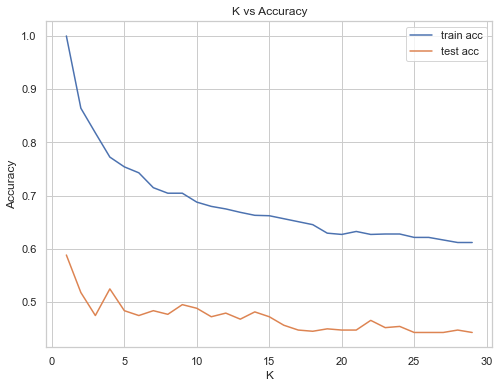

In [324]:
plt.figure(figsize=(8, 6))
plt.title('K vs Accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.plot(range(1,30), train_acc, label='train acc')
plt.plot(range(1,30), test_acc, label='test acc')
plt.legend()


### XgBoost

In [325]:
%%capture --no-display
# XgBoost

model_xgb = xgb.XGBClassifier(random_state=12)
model_xgb.fit(X_train_std, y_train_outlier)

cross_val_score(model_xgb, X_train_std, y_train_outlier, cv=5)

array([0.67330677, 0.73306773, 0.70119522, 0.716     , 0.724     ])

In [326]:
model_xgb.score(X_test_std, y_test_outlier)

0.6545454545454545

In [327]:
y_pred_xgb = model_xgb.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_xgb))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_xgb))

Confusion matrix - tablica pomyłek
 [[  0   2   0   0   0   0]
 [  1   0   6   7   0   0]
 [  1  11 139  34   3   0]
 [  0   1  37 120  15   6]
 [  0   0   3  17  28   5]
 [  0   0   0   0   3   1]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        14
           5       0.75      0.74      0.75       188
           6       0.67      0.67      0.67       179
           7       0.57      0.53      0.55        53
           8       0.08      0.25      0.12         4

    accuracy                           0.65       440
   macro avg       0.35      0.36      0.35       440
weighted avg       0.66      0.65      0.66       440



In [328]:
%%capture --no-display
# Dobór optymalnych parametrów dla modelu (ten etap jest powtarzany kilka razy żeby dobrać najlepsze zakresy)

param_grid_xgb = {
            "n_estimators": [100, 150, 200, 300, 400],
            "max_depth": [2, 5, 10, 20, 30],
            "learning_rate": [0.005, 0.01, 0.05, 0.1, 0.2],
            "booster": ["gbtree"],
#             "min_child_weight": [1, 2, 4, 6, 10, 50],
#             "subsample": [0.5, 0.8],
#             "colsample_bylevel": [0.5, 0.8],
            "reg_alpha": [1, 5, 10],
            "objective": ["multi:softmax"],
            "num_class": [6]
    
}

grid_xgb = GridSearchCV(model_xgb, param_grid=param_grid_xgb, cv=5, scoring="f1_micro", verbose=0, n_jobs=-1)
grid_xgb.fit(X_train_std, y_train_outlier)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=10...
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,
                                     tree_method='exact', validate_parameters=1,
                            

In [329]:
print("Najlepsze parametry: ", grid_xgb.best_params_)
print("Najwyższy score: ", grid_xgb.best_score_)

Najlepsze parametry:  {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150, 'num_class': 6, 'objective': 'multi:softmax', 'reg_alpha': 1}
Najwyższy score:  0.7222916334661355


In [330]:
%%capture --no-display
# Zastosowanie najlepszych parametrów dla modelu

model_xgb_best = xgb.XGBClassifier(random_state=12, **grid_xgb.best_params_)

model_xgb_best.fit(X_train_std, y_train_outlier)

cross_val_score(model_xgb, X_train_std, y_train_outlier, cv=5)

array([0.67330677, 0.73306773, 0.70119522, 0.716     , 0.724     ])

In [331]:
model_xgb_best.score(X_test_std, y_test_outlier)

0.6431818181818182

In [332]:
y_pred_xgb = model_xgb_best.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_xgb))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_xgb, zero_division=1))

Confusion matrix - tablica pomyłek
 [[  0   1   0   0   1   0]
 [  1   0   6   7   0   0]
 [  1   9 145  30   3   0]
 [  0   1  40 110  20   8]
 [  0   0   3  17  27   6]
 [  0   0   0   1   2   1]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        14
           5       0.75      0.77      0.76       188
           6       0.67      0.61      0.64       179
           7       0.51      0.51      0.51        53
           8       0.07      0.25      0.11         4

    accuracy                           0.64       440
   macro avg       0.33      0.36      0.34       440
weighted avg       0.65      0.64      0.65       440



### RANDOM FOREST

In [29]:

model_RF = RandomForestClassifier(random_state=12)
model_RF.fit(X_train_std, y_train_outlier)

cross_val_score(model_RF, X_train_std, y_train_outlier, cv=5)

array([0.76229508, 0.73360656, 0.75409836, 0.76954733, 0.7654321 ])

In [30]:
model_RF.score(X_test_std, y_test_outlier)

0.655328798185941

In [31]:
y_pred_RF = model_RF.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_RF))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_RF))

Confusion matrix - tablica pomyłek
 [[  1   1   1   0   0   0]
 [  1   0   5   8   0   0]
 [  0   8 140  38   1   0]
 [  0   0  43 122  14   1]
 [  0   2   2  22  26   1]
 [  0   0   0   2   2   0]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.50      0.33      0.40         3
           4       0.00      0.00      0.00        14
           5       0.73      0.75      0.74       187
           6       0.64      0.68      0.66       180
           7       0.60      0.49      0.54        53
           8       0.00      0.00      0.00         4

    accuracy                           0.66       441
   macro avg       0.41      0.38      0.39       441
weighted avg       0.65      0.66      0.65       441



In [32]:
param_grid_RF = {"n_estimators": [10, 17, 25, 33, 41, 48, 56, 64, 72, 80,100,200],
    "ccp_alpha" : [0, 0.2, 0.02],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90], 
           "min_samples_split":[3,5,7,9,11,13,15,17,20],
           "bootstrap": [True,False]}

In [33]:
random_search_RF = RandomizedSearchCV(model_RF,
                                   param_distributions=param_grid_RF,
                                   cv=5,
                                   n_iter=500,
                                   verbose=1)
random_search_RF.fit(X_train_std, y_train_outlier)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12),
                   n_iter=500,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': [0, 0.2, 0.02],
                                        'max_depth': [1, 3, 5, 7, 9, 11, 12],
                                        'max_features': ['auto', 'log2', 'sqrt',
                                                         None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [3, 5, 7, 9, 11,
                                                              13, 15, 17, 20],
                                        'min_weight_fraction_

In [34]:
print("Najlepsze parametry: ", random_search_RF.best_params_)
print("Najwyższy score: ", random_search_RF.best_score_)

Najlepsze parametry:  {'n_estimators': 72, 'min_weight_fraction_leaf': 0.1, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_leaf_nodes': 80, 'max_features': 'auto', 'max_depth': 12, 'ccp_alpha': 0, 'bootstrap': True}
Najwyższy score:  0.5582945422653983


In [35]:
param_grid_RF_2 = {"n_estimators": [72,100],
            "max_depth" : [12,20],
           "min_samples_leaf":[9,10],
           "min_weight_fraction_leaf":[0.0,0.1,0.2],
           "max_leaf_nodes":[None,80],
           'max_features': ['auto', 'log2'], 
           "min_samples_split":[13,20]}


In [36]:
grid_RF = GridSearchCV(model_RF, param_grid=param_grid_RF_2, cv=5, scoring="f1_micro", verbose=0, n_jobs=-1)
grid_RF.fit(X_train_std, y_train_outlier)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12), n_jobs=-1,
             param_grid={'max_depth': [12, 20],
                         'max_features': ['auto', 'log2'],
                         'max_leaf_nodes': [None, 80],
                         'min_samples_leaf': [9, 10],
                         'min_samples_split': [13, 20],
                         'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
                         'n_estimators': [72, 100]},
             scoring='f1_micro')

In [37]:
print("Najlepsze parametry: ", grid_RF.best_params_)
print("Najwyższy score: ", grid_RF.best_score_)

Najlepsze parametry:  {'max_depth': 20, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 9, 'min_samples_split': 13, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 72}
Najwyższy score:  0.7241617756189705


In [38]:
model_RF_opt = RandomForestClassifier(random_state=12, max_depth=20, max_features='auto', max_leaf_nodes= None, min_samples_leaf=9,min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=72 )
model_RF_opt.fit(X_train_std, y_train_outlier)

cross_val_score(model_RF_opt, X_train_std, y_train_outlier, cv=5)

array([0.68852459, 0.7295082 , 0.72540984, 0.72839506, 0.74897119])

In [39]:
model_RF_opt.score(X_test_std, y_test_outlier)

0.6507936507936508

In [40]:
y_pred_RF_opt = model_RF_opt.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_RF_opt))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_RF_opt))

Confusion matrix - tablica pomyłek
 [[  1   1   1   0   0   0]
 [  5   3   3   3   0   0]
 [  2   9 140  36   0   0]
 [  1   1  43 127   5   3]
 [  0   3   2  28  14   6]
 [  0   0   0   2   0   2]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.11      0.33      0.17         3
           4       0.18      0.21      0.19        14
           5       0.74      0.75      0.74       187
           6       0.65      0.71      0.68       180
           7       0.74      0.26      0.39        53
           8       0.18      0.50      0.27         4

    accuracy                           0.65       441
   macro avg       0.43      0.46      0.41       441
weighted avg       0.68      0.65      0.65       441



### bez sensu optymalizacja :/

### PCA

In [58]:
pca = PCA(n_components=11)
pca.fit(X_train_outlier)
X_train_pca = pca.transform(X_train_outlier)
X_test_pca = pca.transform(X_test_outlier)


In [59]:
model_RF_PCA = RandomForestClassifier(random_state=12)
model_RF_PCA.fit(X_train_pca, y_train_outlier)

cross_val_score(model_RF_PCA, X_train_pca, y_train_outlier, cv=5)

array([0.696     , 0.712     , 0.712     , 0.71084337, 0.74698795])

In [61]:
model_RF_PCA.score(X_test_pca, y_test_outlier)

0.6613636363636364

In [62]:
y_pred_RF_PCA = model_RF_PCA.predict(X_test_pca)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_RF_PCA))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_RF_PCA))

Confusion matrix - tablica pomyłek
 [[  0   1   1   0   0   0]
 [  1   2   3   8   0   0]
 [  1   6 140  36   4   0]
 [  0   3  40 123  11   3]
 [  0   0   3  22  26   2]
 [  0   0   0   2   2   0]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.17      0.14      0.15        14
           5       0.75      0.75      0.75       187
           6       0.64      0.68      0.66       180
           7       0.60      0.49      0.54        53
           8       0.00      0.00      0.00         4

    accuracy                           0.66       440
   macro avg       0.36      0.34      0.35       440
weighted avg       0.66      0.66      0.66       440



In [63]:
model_RF_opt_PCA = RandomForestClassifier(random_state=12, max_depth=12, max_features='auto', max_leaf_nodes= None, min_samples_leaf=7,min_samples_split=9, min_weight_fraction_leaf=0.0, n_estimators=72 )
model_RF_opt_PCA.fit(X_train_pca, y_train_outlier)

cross_val_score(model_RF_opt_PCA, X_train_pca, y_train_outlier, cv=5)

array([0.644     , 0.696     , 0.692     , 0.68273092, 0.73895582])

In [64]:
model_RF_opt_PCA.score(X_test_pca, y_test_outlier)

0.6136363636363636

In [65]:
y_pred_RF_opt_PCA = model_RF_opt_PCA.predict(X_test_pca)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_RF_opt_PCA))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_RF_opt_PCA))

Confusion matrix - tablica pomyłek
 [[  0   1   1   0   0   0]
 [  2   2   3   7   0   0]
 [  1   9 130  46   1   0]
 [  0   3  50 121   2   4]
 [  0   0   2  30  17   4]
 [  0   0   0   3   1   0]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.13      0.14      0.14        14
           5       0.70      0.70      0.70       187
           6       0.58      0.67      0.63       180
           7       0.81      0.32      0.46        53
           8       0.00      0.00      0.00         4

    accuracy                           0.61       440
   macro avg       0.37      0.31      0.32       440
weighted avg       0.64      0.61      0.61       440

